## Generating Qiskit's Data

In [ ]:
!pip install -qq -U "classiq[qml]"

In [1]:
from itertools import combinations

from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
from sklearn.svm import SVC

from classiq import *

seed = 12345
algorithm_globals.random_seed = seed

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5 + 5,  # 5 for test, 5 for predict
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

In [2]:
# the sizes of the `test_features` and `test_labels` are double those of the `test_size` argument
# Since there are `test_size` items for each `adhoc_dimension`
import numpy as np


def split(obj: np.ndarray, n: int = 20):
    quarter = n // 4
    half = n // 2
    first = np.concatenate((obj[:quarter], obj[half : half + quarter]))
    second = np.concatenate((obj[quarter:half], obj[half + quarter :]))
    return first, second


test_features, predict_features = split(test_features)
test_labels, predict_labels = split(test_labels)

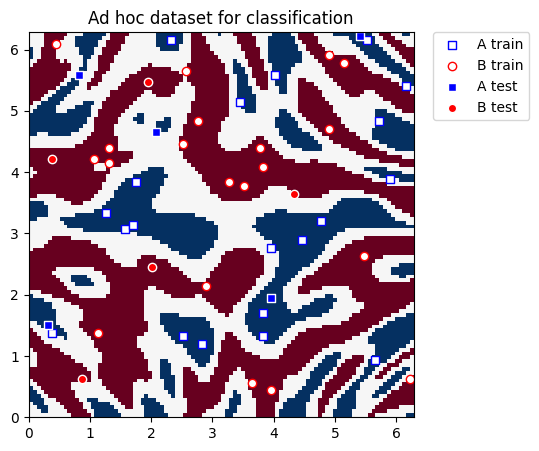

In [3]:
# Plot data
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],
    test_features[np.where(test_labels[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],
    test_features[np.where(test_labels[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

## Building Classiq's QSVM

We build a Pauli feature map. This feature map is of size $N$ qubits for data $\vec{x}$ of size $N$, and it corresponds to the following unitary:
$$
U = \left(\hbox{Hadamarad Transform}\right) \exp\left(\sum f^{(1)}_k(\vec{x})H^{(1)}_k + \sum f^{(2)}_k(\vec{x})H^{(2)}_k+\dots \right),
$$
where $H^{(i)}$ is a Hamiltonian acting on $i$ qubits according to some connectivity map, and $f^{(i)}$ is some classical function, typically taken as the polynomial of degree $i$. For example, if our data is of size $3$ and we assume circular connectivity, taking Hamiltonians depending only on $Z$, the Hamiltonian reads as
$$
\sum f^{(1)}_k(\vec{x})H^{(1)}_k = \alpha(x_0+\beta)ZII+\alpha(x_1+\beta)IZI+\alpha(x_2+\beta)IIZ,
$$
$$
\sum f^{(2)}_k(\vec{x})H^{(2)}_k = \gamma^2(x_0+\zeta)(x_1+\zeta)ZZI+\gamma^2(x_1+\zeta)(x_2+\zeta)IZZ + \gamma^2(x_0+\zeta)(x_3+\zeta)ZIZ,
$$
where $(\alpha,\beta)$ and $(\gamma,\zeta)$ define some affine transformation on the data and correspond to the functions $f^{(1,2)}$.

We start with defining classical functions for creating a connectivity map for the Hamiltonians and for generating the full Hamiltonian:

In [4]:
from itertools import combinations, islice

import numpy as np

from classiq import *


def generate_connectivity_map(list_size, sublist_size, connectivity_type):
    """
    Generate connectivity for a given list size and sublist size.

    Parameters:
    - list_size: The size of the list (number of elements).
    - sublist_size: The size of the subsets to generate.
    - connectivity_type: an integer (0 for linear, 1 for circular, 2 for full)

    Returns:
    - A list of all unique subsets of the given size.
    """
    assert connectivity_type in [
        0,
        1,
        2,
    ], "connectivity must be 0 (linear), 1 (circular), or 2 (full)"

    if connectivity_type == 0:  # linear
        return [
            list(range(i, i + sublist_size))
            for i in range(list_size - sublist_size + 1)
        ]

    elif connectivity_type == 1:  # circular
        return [
            [(i + j) % list_size for j in range(sublist_size)] for i in range(list_size)
        ]

    elif connectivity_type == 2:  # full
        return [list(comb) for comb in combinations(range(list_size), sublist_size)]


def generate_hamiltonian(
    data: CArray[CReal],
    paulis_list: list[list[Pauli]],
    affines: list[list[float]],
    connectivity: int,
) -> tuple[list[SparsePauliOp], list[CReal]]:
    assert connectivity in [
        0,
        1,
        2,
    ], "connectivity must be 0 (linear), 1 (circular) or 2 (full)"
    hs = []
    coeffs = []
    for paulis, affine in zip(paulis_list, affines):
        indices = generate_connectivity_map(data.len, len(paulis), connectivity)
        for k in range(len(indices)):
            indexed_paulis = [
                IndexedPauli(pauli=paulis[j], index=indices[k][j])
                for j in range(len(indices[0]))
            ]
            hs.append(
                SparsePauliOp(
                    terms=[SparsePauliTerm(paulis=indexed_paulis, coefficient=1)],
                    num_qubits=data.len,
                )
            )
            coe = np.prod(
                [
                    affine[0] * (data[indices[k][j]] - affine[1])
                    for j in range(len(indices[0]))
                ]
            )
            coeffs.append(coe)

    return hs, coeffs

Next, we define a quantum function for the Pauli feature map:

In [5]:
@qfunc
def pauli_kernel(
    data: CArray[CReal],
    paulis_list: list[list[Pauli]],
    affines: list[list[float]],
    connectivity: int,
    reps: CInt,
    qba: QArray,
) -> None:
    hs, coeffs = generate_hamiltonian(data, paulis_list, affines, connectivity)
    power(
        reps,
        lambda: (
            hadamard_transform(qba),
            multi_suzuki_trotter(
                hamiltonians=hs,
                evolution_coefficients=coeffs,
                order=1,
                repetitions=1,
                qbv=qba,
            ),
        ),
    )

Finally, we construct the quantum model for the QSVM routine:

In [6]:
N_DIM = 2
PAULIS = [[Pauli.Z], [Pauli.Z, Pauli.Z]]
CONNECTIVITY = 2
AFFINES = [[1, 0], [1, np.pi]]
REPS = 2

In [7]:
@qfunc
def main(data1: CArray[CReal, N_DIM], data2: CArray[CReal, N_DIM], qba: Output[QNum]):
    allocate(data1.len, qba)
    pauli_kernel(data1, PAULIS, AFFINES, CONNECTIVITY, REPS, qba)
    invert(lambda: pauli_kernel(data2, PAULIS, AFFINES, CONNECTIVITY, REPS, qba))


QSVM_PAULI_Z_ZZ = create_model(main)
write_qmod(QSVM_PAULI_Z_ZZ, "qsvm_pauli_feature_map", symbolic_only=False)

## Viewing the Model's Parameterized Quantum Circuit

In [8]:
qprog = synthesize(QSVM_PAULI_Z_ZZ)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/32pQjDiThYtHON7LiLZxkiekrmq


## Executing QSVM
The first step in QSVM is the training.
The second step in QSVM is to test the training process.
The last QSVM step, which may be applied multiple times on different datasets, is prediction: the prediction process takes unlabeled data and returns its predicted labels.

Next, we define classical functions for applying these three parts of the execution, where the latter is done via `ExecutionSession` and `batch_sample`.

In [9]:
def get_execution_params(data1, data2=None):
    """
    Generate execution parameters based on the mode (train or validate).

    Parameters:
    - data1: First dataset (used for both training and validation).
    - data2: Second dataset (only required for validation).

    Returns:
    - A list of dictionaries with execution parameters.
    """
    if data2 is None:
        # Training mode (symmetric pairs of data1)
        return [
            {"data1": data1[k], "data2": data1[j]}
            for k in range(len(data1))
            for j in range(k, len(data1))  # Avoid symmetric pairs
        ]
    else:
        # Prediction mode
        return [
            {"data1": data1[k], "data2": data2[j]}
            for k in range(len(data1))
            for j in range(len(data2))
        ]


def construct_kernel_matrix(matrix_size, res_batch, train=False):
    """
    Construct a kernel matrix from `res_batch`, depending on whether it's for training or predicting.

    Parameters:
    - matrix_size: Tuple of (number of rows, number of columns) for the matrix.
    - res_batch: Precomputed batch results.
    - train: Boolean flag. If True, assumes training (symmetric matrix).

    Returns:
    - A kernel matrix as a NumPy array.
    """
    rows, cols = matrix_size
    kernel_matrix = np.zeros((rows, cols))

    num_shots = res_batch[0].num_shots
    num_output_qubits = len(next(iter(res_batch[0].counts)))

    count = 0
    if train:  # and rows == cols:
        # Symmetric matrix (training)
        for k in range(rows):
            for j in range(k, cols):
                value = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                kernel_matrix[k, j] = value
                kernel_matrix[j, k] = value  # Use symmetry
                count += 1
    else:
        # Non-symmetric matrix (validation)
        for k in range(rows):
            for j in range(cols):
                kernel_matrix[k, j] = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                count += 1

    return kernel_matrix


def train_svm(es, train_data, train_labels):
    """
    Trains an SVM model using a custom precomputed kernel from the training data.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - train_data: List of data points for training.
    - train_labels: List of binary labels corresponding to the training data.

    Returns:
    - svm_model: A trained SVM model using the precomputed kernel.
    """
    train_size = len(train_data)
    train_execution_params = get_execution_params(train_data)
    res_train_batch = es.batch_sample(train_execution_params)  # execute batch
    # generate kernel matrix for train
    kernel_train = construct_kernel_matrix(
        matrix_size=(train_size, train_size), res_batch=res_train_batch, train=True
    )
    svm_model = SVC(kernel="precomputed")
    svm_model.fit(
        kernel_train, train_labels
    )  # the fit gets the precomputed matrix of training, and the training labels

    return svm_model


def predict_svm(es, data, train_data, svm_model):
    """
    Predicts labels for new data using a precomputed kernel with a trained SVM model.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - data (list): List of new data points to predict.
    - train_data (list): Original training data used to train the SVM.
    - svm_model: A trained SVM model returned by `train_svm`.

    Returns:
    - y_predict (list): Predicted labels for the input data.
    """
    predict_size = len(data)
    train_size = len(train_data)
    predict_execution_params = get_execution_params(data, train_data)
    res_predict_batch = es.batch_sample(predict_execution_params)  # execute batch
    kernel_predict = construct_kernel_matrix(
        matrix_size=(predict_size, train_size), res_batch=res_predict_batch, train=False
    )
    y_predict = svm_model.predict(
        kernel_predict
    )  # the predict gets the precomputed test matrix

    return y_predict

We can now run the execution session with all three parts:

In [10]:
from classiq.execution import ExecutionSession

with ExecutionSession(qprog) as es:
    # train
    svm_model = train_svm(es, train_features.tolist(), train_labels.tolist())

    # test
    y_test = predict_svm(es, test_features.tolist(), train_features.tolist(), svm_model)
    test_score = sum(y_test == test_labels.tolist()) / len(test_labels.tolist())
    # print("quantum kernel classification test score:  %0.2f" % (test_score))

    # predict
    predicted_labels = predict_svm(
        es, predict_features.tolist(), train_features.tolist(), svm_model
    )

In [11]:
# Printing tests result
print(f"Testing success ratio: {test_score}")
print()
# Printing predictions
print("Prediction from datapoints set:")
print(f"  ground truth: {predict_labels}")
print(f"  prediction:   {predicted_labels}")
print(
    f"  success rate: {100 * np.count_nonzero(predicted_labels == predict_labels) / len(predicted_labels)}%"
)

Testing success ratio: 1.0

Prediction from datapoints set:
  ground truth: [0 0 0 0 0 1 1 1 1 1]
  prediction:   [0 0 0 0 0 1 1 1 1 1]
  success rate: 100.0%
